### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import scipy.io.wavfile as wav
import scipy

from sklearn.model_selection import train_test_split

import os

##### Install dependencies and unzip dataset 

In [2]:
!pip install py7zr
!py7zr x '../input/tensorflow-speech-recognition-challenge/train.7z'
!py7zr x '../input/tensorflow-speech-recognition-challenge/test.7z'

     |████████████████████████████████| 66 kB 334 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 536 kB/s eta 0:00:01
     |████████████████████████████████| 124 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.1 MB/s eta 0:00:01


### Create train-dataset

In [10]:
TRAIN_DIR = './train/audio'
labels = os.listdir(TRAIN_DIR)

Dataset of all labels except silence

In [3]:
X = []
Y = []
for label in labels:
    path = os.path.join(TRAIN_DIR, label)
    filenames = os.listdir(path)
    for filename in filenames:
        if ".wav" not in filename or label == "_background_noise_":
            continue
        audio, sr = librosa.load(os.path.join(path, filename))
        audio = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=128) # Generate MFCC of the audio sample
        audio = np.pad(audio, ((0, 0), (0, 50-audio.shape[1])), mode="constant", constant_values=0)
        X.append(audio)
        Y.append(labels.index(label))

Dataset creation of silence label

In [4]:
label = "_background_noise_"
path = os.path.join(TRAIN_DIR, label)
filenames = os.listdir(path)
for filename in filenames:
    if ".wav" not in filename:
        continue
    audio, sr = librosa.load(os.path.join(path, filename))
    for i in range(0, sr, sr):
        a = librosa.feature.mfcc(y = audio[i:i+sr], sr=sr, n_mfcc=128)
        a = np.pad(a, ((0, 0), (0, 50-a.shape[1])), mode="constant", constant_values=0)
        X.append(a)
        Y.append(labels.index(label))

In [5]:
X = np.asarray(X)
X = np.expand_dims(X, -1)
Y = np.asarray(Y)
X.shape, Y.shape

((64727, 128, 50, 1), (64727,))

### Train-Test Split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

### Model Creation & Training

In [8]:
def Model(X, dropout=0.4):
    _input = tf.keras.layers.Input(X)
    x = tf.keras.layers.Conv2D(16, (3,3))(_input)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3))(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3))(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(len(labels))(x)
    x = tf.keras.layers.Activation(tf.nn.softmax)(x)
    return tf.keras.Model(_input, x)

In [7]:
model = Model(x_train[0].shape)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
checkpoint_filepath = "weights_mfcc_Conv2D/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
H = model.fit(x_train, y_train, batch_size=256, epochs=500, validation_split=0.25, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/500
143/143 [==============================] - 10s 36ms/step - loss: 3.4847 - accuracy: 0.1107 - val_loss: 2.2344 - val_accuracy: 0.3708
Epoch 2/500
143/143 [==============================] - 4s 29ms/step - loss: 2.3537 - accuracy: 0.3130 - val_loss: 2.2463 - val_accuracy: 0.3647
Epoch 3/500
143/143 [==============================] - 4s 30ms/step - loss: 1.9661 - accuracy: 0.4151 - val_loss: 2.4170 - val_accuracy: 0.3433
Epoch 4/500
143/143 [==============================] - 4s 30ms/step - loss: 1.6963 - accuracy: 0.4932 - val_loss: 1.8920 - val_accuracy: 0.4719
Epoch 5/500
143/143 [==============================] - 4s 29ms/step - loss: 1.5205 - accuracy: 0.5426 - val_loss: 2.1297 - val_accuracy: 0.4429
Epoch 6/500
143/143 [==============================] - 4s 29ms/step - loss: 1.3725 - accuracy: 0.5860 - val_loss: 1.2021 - val_accuracy: 0.6430
Epoch 7/500
143/143 [==============================] - 4s 29ms/step - loss: 1.2700 - accuracy: 0.6152 - val_loss: 1.2915 - val_accuracy

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

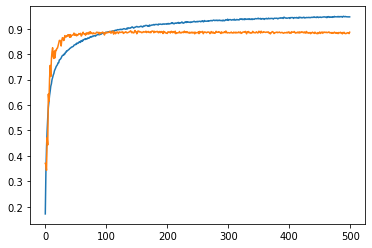

In [8]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

Load the best weights and evaluate the model

In [9]:
model.load_weights("weights_mfcc_Conv2D/")
model.evaluate(x_test, y_test)

506/506 [==============================] - 1s 3ms/step - loss: 0.3814 - accuracy: 0.8961


[0.3813636302947998, 0.8961191177368164]

Save the model weights in a zip file (for downloading from server)

In [10]:
!zip -r 'weights_mfcc_Conv2D.zip' 'weights_mfcc_Conv2D/'

  adding: weights_mfcc_Conv2D/ (stored 0%)
  adding: weights_mfcc_Conv2D/.data-00000-of-00001 (deflated 9%)
  adding: weights_mfcc_Conv2D/checkpoint (deflated 34%)
  adding: weights_mfcc_Conv2D/.index (deflated 72%)


### Create Test-Dataset

In [3]:
TEST_DIR = './test/audio'

In [4]:
filenames = os.listdir(TEST_DIR)
X_Test = []
for filename in filenames:
    if ".wav" not in filename:
        continue
    audio, sr = librosa.load(os.path.join(TEST_DIR, filename))
    audio = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=128)
    audio = np.pad(audio, ((0, 0), (0, 50-audio.shape[1])), mode="constant", constant_values=0)
    X_Test.append(audio)

In [6]:
X_Test = np.asarray(X_Test)
X_Test = np.expand_dims(X_Test, -1)
X_Test.shape

(158538, 128, 50, 1)

### Load weights and predict class labels for test set provided for the challenge

In [11]:
checkpoint_filepath = "weights_mfcc_Conv2D/"
model = Model(X_Test[0].shape)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.load_weights(checkpoint_filepath)

In [12]:
pred = model.predict(X_Test)

##### Create csv file for the predicted labels in the format specified for submission

In [25]:
_fname = []
_labels = []
ans_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
for i in range(len(X_Test)):
    y = np.argmax(pred[i])
    y = labels[y]
    if y not in ans_labels:
        if y == "_background_noise_":
            y = "silence"
        else:
            y = "unknown"
    _fname.append(filenames[i])
    _labels.append(y)

In [26]:
df = pd.DataFrame.from_dict({'fname':_fname, 'label':_labels})
df.head()

,fname,label
0,clip_3d93954fa.wav,unknown
1,clip_ee3946a25.wav,left
2,clip_8d9db8225.wav,up
3,clip_b23b8241f.wav,yes
4,clip_6c785c104.wav,unknown


Save dataframe as csv

In [27]:
df.to_csv('submission.csv', index=False)